# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='...')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent_project import Agent

### HyperParameters

- Buffer size : $10^6$ 
- Batch size : 64
- Discount factor : 0.99
- Tau for soft update : 0.001
- Learning rate of actor network : 0.0001
- Learning rate of critic network : 0.001

### Network Explanation

- Actor Network : Fully connected layers

    The first hidden layer has 256 nodes.
    
    At this hidden layer, leaky relu function is applied as an activation function.
    
    Tanh is applied at the last layer to generate an output whose value is [-1,1].
    
    
- Critic Network : Fully connected layers

    The first hidden layer has 256 nodes, the second hidden layer has 128 nodes, and the third hidden layer has 128 nodes.
    
    At those hidden layers, leaky relu function is applied as an activation function.



# Single Agent Training!

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='...')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

def ddpg_1(n_episodes=200, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    env_info = env.reset(train_mode=True)[brain_name] 
    time_steps = 2
    solved = False
    score = np.zeros(num_agents)
        
    for i_episode in range(1, n_episodes+1):
        state = env_info.vector_observations
        
        agent.reset()
        
        for t in range(max_t):
            action = agent.act(state)                      # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done
            
            step_t = zip(state, action, reward, next_state, done)
            
            for state, action, reward, next_step, done in step_t:
                agent.memory.add(state, action, reward, next_step, done)
                if ( t % time_steps == 0):
                    agent.step(state, action, reward, next_step, done)
            state  = next_state
            score += reward
            
            #agent.step(state, action, reward, next_state, done)
            #state = next_state
            #score += reward
            if done:
                break 
                
        scores_deque.append(score)
        scores.append([i_episode, score[0]])
        
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}', end="")
    
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if not solved and np.mean(scores_deque) > 30.:
            target_episode = i_episode
            print(f"\r\rEnviroment solved in @ {i_episode}, w/ avg_score={np.mean(scores_deque):.2f}\r")
            solved= True
            
            
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_1.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            
    return scores, target_episode

scores_1 = ddpg_1()

Episode 100	Average Score: 18.75
Enviroment solved in @ 173, w/ avg_score=30.30
Episode 200	Average Score: 33.44


Text(0.5,1,'single agent training')

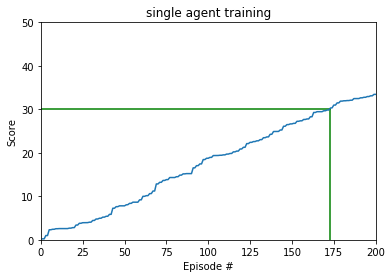

In [7]:
plt.plot([scores_1[1],scores_1[1]],[0,30],'g')
plt.plot([0,scores_1[1]],[30,30],'g')
plt.plot(np.transpose(scores_1[0])[0],np.transpose(scores_1[0])[1])
plt.xlim([0,200])
plt.ylim([0,50])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('single agent training')

In [8]:
env.close()

# 20 Agents training!

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='...')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent_project import Agent

In [5]:
agents = [Agent(state_size=state_size, action_size=action_size, random_seed=2) for _ in range(num_agents)]

def ddpg_20(n_episodes=250, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    env_info = env.reset(train_mode=True)[brain_name] 
    time_steps = 20
    solved = False
    score = np.zeros(num_agents)
        
    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
        
        for t in range(max_t):
            actions = np.zeros((num_agents,action_size))
            for i in range(num_agents):
                actions[i] = agents[i].act(states[i])
            
            #actions = agent.act(states)                      # select an action
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            
            step_t = zip(agents, states, actions, rewards, next_states, dones)
            
            for agent, state, action, reward, next_step, done in step_t:
                agent.memory.add(state, action, reward, next_step, done)
                if ( t % time_steps == 0):
                    agent.step(state, action, reward, next_step, done)
            states  = next_states
            score += np.mean(rewards)
            
            #agent.step(state, action, reward, next_state, done)
            #state = next_state
            #score += reward
            if np.any(dones):
                break 
                
        scores_deque.append(score)
        scores.append([i_episode, score[0]])
        
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}', end="")
    
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if not solved and np.mean(scores_deque) > 30.:
            target_episode = i_episode
            print(f"\r\rEnviroment solved in @ {i_episode}, w/ avg_score={np.mean(scores_deque):.2f}\r")
            solved= True
            
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_20.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_20.pth')
            
    return scores, target_episode

scores_20 = ddpg_20()


Episode 100	Average Score: 11.68
Episode 200	Average Score: 24.25
Enviroment solved in @ 245, w/ avg_score=30.19
Episode 250	Average Score: 30.75

Text(0.5,1,'20 agents training')

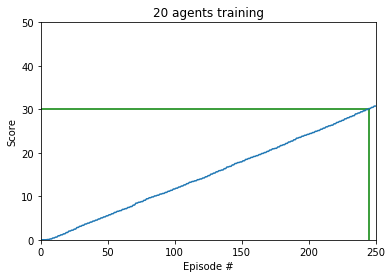

In [7]:
plt.plot([scores_20[1],scores_20[1]],[0,30],'g')
plt.plot([0,scores_20[1]],[30,30],'g')
plt.plot(np.transpose(scores_20[0])[0],np.transpose(scores_20[0])[1])
plt.xlim([0,250])
plt.ylim([0,50])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('20 agents training')

In [ ]:
env.close()

# Future Improvement

- Prioritized Experience Replay

    A better sampling strategy may enhance the learning speed.